In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.table import Table

%matplotlib widget
from tqdm import trange

import physicsConsts as c
from simulation_functions import get_AM3, blastwave, powerlaw_array
from plotting_functions import plot_spectrum, plot_coolingtimes, Eobs_av, dens2flux_av
import setFigureConfig as sfc

from colorschemes import get_comp_cols
compcols = get_comp_cols()


# set up AM3

In [2]:
am3 = get_AM3(exp=0, hadronic=1, qsyn=1) # expansion needed for time dependent method
am3.init_kernels()

init. AM3 kernels:
AM3 has the following switches (at step: 0)
estimate maximum energies: 0
parse sed components: 1
escape: 1
expansion: 0
adiabatic: 1
synchrotron:
  e+/-: 1  (em..: 1, cool.: 1)
  protons:1  (em..: 1, cool.: 1)
  pions:1  (em..: 1, cool.: 1)
  muons:1  (em..: 1, cool.: 1)
  syn-self-abs.:1
  e+/- quantum-syn.:1
inv. Compton:
  e+/-: 1  (em.. : 1, cool.: 1 (continuous))
  photon loss due to upscattering: 1
  protons:1  (em.. (step approx.): 1, no cooling)
  pions:1  (em.. (step approx.): 1, cont. cool.: 1)
  muons:1  (em.. (step approx.): 1, cont. cool.: 1)
pair prod. (gamma+gamma->e+e)1  (photon loss.: 1, e+/- source (feedback): 1(opt. 14-bin kernel))
'hadronic' processes (below): 1
 Pion decay: 1 Muon decay:1)
proton Bethe-Heitler: 1  (em..: 1, cool.: 1)
proton photo-pion: 1  (em..: 1, cool.: 1, photon loss: 1)
proton p-p: 1  (em..: 1 , cool.: 1)

AM3 params (comoving):
escape_timescale: 1e+06 s
  with fractions: (protons: 1, neutrons: 1, pions: 1, muons: 1, neutrino

In [3]:
# short cuts for energy grids
Ee_eV = am3.get_egrid_lep()
Ee_erg = Ee_eV * c.eV2erg
Eg_eV = am3.get_egrid_photons()
Eg_erg = Eg_eV * c.eV2erg
Ep_eV = am3.get_egrid_had()
Ep_erg = Ep_eV * c.eV2erg
En_eV = am3.get_egrid_neutrinos()
En_erg = En_eV * c.eV2erg

In [4]:
z = 0.1
Ntdyn = 5
fdt = 1e-2 # time step as a fraction of dynamical time

## proton-syn scenario

In [5]:
Gamma = 10**1.7
n = 100 # cm^-3
t_obs = 1e3 # s
epsilon_B = 10**-1
epsilon_e = 10**-4.5
epsilon_p = 10**-3
p = 2
Emin = 10**9 # eV
eta = 1

am3.clear_particle_densities()
# update parameters
am3.set_electron_accel_factor(eta)
am3.set_proton_accel_factor(eta)
am3.set_escape_fraction_charged_particles(0)
am3.set_escape_fraction_neutral_particles(1)
t_dyn, n_target, p_ram_eval, B = blastwave(t_obs, Gamma, n, t_obs, epsilon_B)
am3.set_escape_timescale(t_dyn)
am3.set_expansion_timescale(t_dyn)
am3.set_solver_time_step(fdt * t_dyn)
am3.set_pp_target_proton_density(n_target)
am3.set_mag_field(B)

N_evo = int(Ntdyn/fdt)

for i in trange(N_evo):
    # estimate max. energy
    if i>0:
        am3.estimate_max_electron_energy()
        Eemax = am3.get_estimated_electron_emax()
        am3.estimate_max_proton_energy()
        Epmax = am3.get_estimated_proton_emax()
    else: # use small value for first step
        Eemax = 10*Emin
        Epmax = 10*Emin
    # update injection spectra
    am3.set_injection_rate_electrons(
        Ee_erg*powerlaw_array(
            Ee_erg, Emin*c.eV2erg, Eemax*c.eV2erg, p, epsilon_e*p_ram_eval / t_dyn))
    am3.set_injection_rate_protons(
        Ep_erg*powerlaw_array(
            Ep_erg, Emin*c.eV2erg, Epmax*c.eV2erg, p, epsilon_p*p_ram_eval / t_dyn))
    
    am3.evolve_step()
SED_ss_proton_syn = am3.get_photons()

100%|██████████| 500/500 [00:27<00:00, 18.38it/s]


## pp-cascade scenario

In [6]:
Gamma = 10**1.3667
n = 1e3 # cm^-3
t_obs = 1e3 # s
epsilon_B = 10**-4.5
epsilon_e = 10**-6.5
epsilon_p = 10**0
p = 2.1
Emin = 10**9 # eV
eta = 3

am3.clear_particle_densities()
# update parameters
am3.set_electron_accel_factor(eta)
am3.set_proton_accel_factor(eta)
am3.set_escape_fraction_charged_particles(0)
am3.set_escape_fraction_neutral_particles(1)
t_dyn, n_target, p_ram_eval, B = blastwave(t_obs, Gamma, n, t_obs, epsilon_B)
am3.set_escape_timescale(t_dyn)
am3.set_expansion_timescale(t_dyn)
am3.set_solver_time_step(fdt * t_dyn)
am3.set_pp_target_proton_density(n_target)
am3.set_mag_field(B)

N_evo = int(Ntdyn/fdt)

for i in trange(N_evo):
    # estimate max. energy
    if i>0:
        am3.estimate_max_electron_energy()
        Eemax = am3.get_estimated_electron_emax()
        am3.estimate_max_proton_energy()
        Epmax = am3.get_estimated_proton_emax()
    else: # use small value for first step
        Eemax = 10*Emin
        Epmax = 10*Emin
    # update injection spectra
    am3.set_injection_rate_electrons(
        Ee_erg*powerlaw_array(
            Ee_erg, Emin*c.eV2erg, Eemax*c.eV2erg, p, epsilon_e*p_ram_eval / t_dyn))
    am3.set_injection_rate_protons(
        Ep_erg*powerlaw_array(
            Ep_erg, Emin*c.eV2erg, Epmax*c.eV2erg, p, epsilon_p*p_ram_eval / t_dyn))
    
    am3.evolve_step()
SED_ss_pp_cascade = am3.get_photons()

100%|██████████| 500/500 [00:26<00:00, 18.56it/s]


## p $\gamma$ -cascade scenario

In [7]:
Gamma = 10**1.7
n = 1e3 # cm^-3
t_obs = 1e3 # s
epsilon_B = 10**-5
epsilon_e = 10**-4.5
epsilon_p = 10**0
p = 2
Emin = 10**9.5 # eV
eta = 1

am3.clear_particle_densities()
# update parameters
am3.set_electron_accel_factor(eta)
am3.set_proton_accel_factor(eta)
am3.set_escape_fraction_charged_particles(0)
am3.set_escape_fraction_neutral_particles(1)
t_dyn, n_target, p_ram_eval, B = blastwave(t_obs, Gamma, n, t_obs, epsilon_B)
am3.set_escape_timescale(t_dyn)
am3.set_expansion_timescale(t_dyn)
am3.set_solver_time_step(fdt * t_dyn)
am3.set_pp_target_proton_density(n_target)
am3.set_mag_field(B)

N_evo = int(Ntdyn/fdt)

for i in trange(N_evo):
    # estimate max. energy
    if i>0:
        am3.estimate_max_electron_energy()
        Eemax = am3.get_estimated_electron_emax()
        am3.estimate_max_proton_energy()
        Epmax = am3.get_estimated_proton_emax()
    else: # use small value for first step
        Eemax = 10*Emin
        Epmax = 10*Emin
    # update injection spectra
    am3.set_injection_rate_electrons(
        Ee_erg*powerlaw_array(
            Ee_erg, Emin*c.eV2erg, Eemax*c.eV2erg, p, epsilon_e*p_ram_eval / t_dyn))
    am3.set_injection_rate_protons(
        Ep_erg*powerlaw_array(
            Ep_erg, Emin*c.eV2erg, Epmax*c.eV2erg, p, epsilon_p*p_ram_eval / t_dyn))
    
    am3.evolve_step()
SED_ss_pg_cascade = am3.get_photons()

100%|██████████| 500/500 [00:30<00:00, 16.47it/s]


In [8]:
Eg_eV_psyn, SED_timedep_proton_syn = np.genfromtxt("proton-syn-photons.txt", skip_header=1, delimiter=",").T
Eg_eV_ppcasc, SED_timedep_pp_cascade = np.genfromtxt("pp-cascade-photons.txt", skip_header=1, delimiter=",").T
Eg_eV_pgcasc, SED_timedep_pg_cascade = np.genfromtxt("pg-cascade-photons.txt", skip_header=1, delimiter=",").T


# plots

/lustre/fs23/group/that/mklinger/conda/miniconda3/envs/am3/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


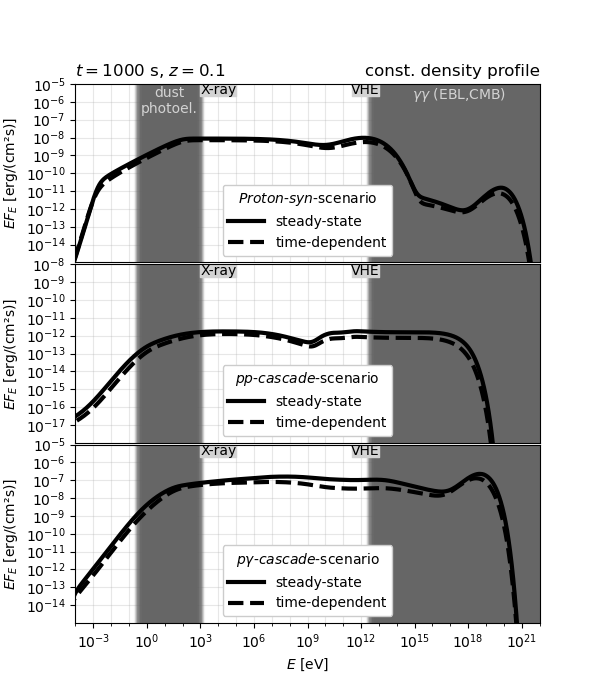

In [10]:
%matplotlib widget
fig, axes = plt.subplots(nrows=3, figsize=(6,7), gridspec_kw={'height_ratios': [1, 1, 1], "hspace":0.01})
titles = [r"$Proton$-$syn$-scenario", r"$pp$-$cascade$-scenario",r"$p\gamma$-$cascade$-scenario" ]
Gammas = [10**1.7, 10**1.3667, 10**1.7]
SEDs_ss = [SED_ss_proton_syn, SED_ss_pp_cascade, SED_ss_pg_cascade]
SEDs_timedep = [SED_timedep_proton_syn, SED_timedep_pp_cascade, SED_timedep_pg_cascade]
Egs_timedep = [Eg_eV_psyn, Eg_eV_ppcasc, Eg_eV_pgcasc]
rangefac = [1, 1e-3, 1]
for i in range(len(axes)):
    labels_grey=["dust\nphotoel.", r"$\gamma \gamma$ (EBL,CMB)"]
    if i>0:
        labels_grey= ["",""]
    
    Gamma_i = Gammas[i]
    axes[i] = plot_spectrum(
        axes[i], z, Gamma_i, t_obs, Eg_eV=Eg_eV, En_eV=En_eV, 
        E2dN_dE_tot_gamma=Eg_erg*0, 
        E2dN_dE_tot_nu=En_erg*0,
        components=[
            [Eg_erg*SEDs_ss[i], "k", False, 0, "-", "steady-state", 3],
            # [SEDs_timedep[i], "k", False, 0, "--", "time-dependent", 3],
        ], ylim=[1e-14*rangefac[i], 1e-5*rangefac[i]], xlim=[1e-4, 1e22], cgrey="#666666", labels_grey=labels_grey
    )
    axes[i].plot(Egs_timedep[i], SEDs_timedep[i], c="k", ls="--", lw=3, label="time-dependent")
    axes[i].set_ylim(axes[i].get_ylim()[0]*1e-1, axes[i].get_ylim()[1])
    axes[i].legend(loc="lower center", framealpha=1, title=titles[i], handlelength=2.6)

for i in [1, 2]:
    axes[i].set_title("", loc="left")
for i in [0, 1]:
    axes[i].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    axes[i].set_xlabel("")
axes[2].tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
axes[0].set_title("const. density profile", loc="right")
fig.tight_layout()
sfc.saveFigure(fig, "quasi-steady-state-had-scenarios")